# Training the SPOCK model when Integrating to one secular time scale
in accordance with Yang & Tamayo

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

Start by loading the training data generated with genNewTrainData.ipynb

In [2]:
#load datapath for clean training data
datapath = '../../cleanData/csvs/resonant/'

dataset = pd.read_csv(datapath+'Int1Tsec.csv')
#cleanTmaxData.csv for int to Tmax
#TmaxOr1e4.csv for into to 1e4 or Tmax, whichever is greater
#remove junk columns
dataset = dataset.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

In [3]:
dataset['InitialStable'].value_counts()

InitialStable
1.0    95968
0.0     6529
Name: count, dtype: int64

We can then split the data into training and testing sets, note, we will remove systems that go unstable in 1e4 orbits from the testing set

In [4]:
def train_test(dataset,features):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in 1e4 orbits

    test = test.drop(test[test['InitialStable']==False].index)
    #test = test.drop(test[test['logTmax']>3.75].index)
    return train[features], train['Stable'], test[features], test['Stable']

In [5]:
dataset['logTmax']=np.log10(dataset['Tmax'])

In [6]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear']
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar']
megno = ['MEGNO', 'MEGNOstd']

features = near + far + megno + ['Tmax']


trainX, trainY, testX, testY = train_test(dataset, features)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

# Tuning hyperparameter
We can determine the idea values for the different hyperparameters.

We will start by creating and testing a collection of models that have randomly selected hyperparameters

scale_pos_weight is a hyperparameter used to account for skewed training data, it does this by weighting false positives and negatives differently. A typical value can be obtained by dividing your negative outcomes in your training data by your positive outcomes.

In [7]:
trainingBalance = trainY.value_counts()[False]/trainY.value_counts()[True]

We can then establish the different parameter space that we will be testing different hyperparameter values within.

In [8]:
space ={'max_depth': hp.qloguniform('x_max_depth', np.log(5), np.log(40), 1),
        'min_child_weight': hp.loguniform('x_min_child', 0, np.log(30)),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 150,
                            max_depth = int(params['max_depth']), 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            learning_rate = 0.15, seed = 0,
                            scale_pos_weight = trainingBalance)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}


We can then create and evaluate the different trials

In [9]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 100, trials = trials, rstate=np.random.default_rng(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

SCORE:                                                 
0.9334999425968551                                     
ERROR                                                  
0.002368817192979471                                   
SCORE:                                                                            
0.9336744142487067                                                                
ERROR                                                                             
0.002400035403117155                                                              
SCORE:                                                                            
0.9381358689572478                                                                
ERROR                                                                             
0.002656659052561743                                                              
SCORE:                                                                             
0.9328028029277811          

We can not determine what values for hyperparameters will be ideal. We can do this by plotting how AUC changes as we alter each hyperparameter.

Here we will find that an optimal max_depth would be 15, which gives the best performance without over fitting.

Text(0, 0.5, 'CV AUC')

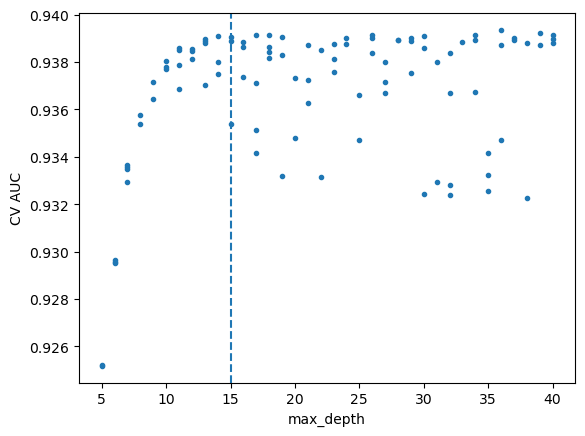

In [ ]:
depths = trials.vals['x_max_depth']
min_childs = trials.vals['x_min_child']
subsample = trials.vals['x_subsample']
aucs = np.array([1-x['loss'] for x in trials.results])
fig, ax = plt.subplots()
ax.plot(depths, aucs, '.')
ax.axvline(15, linestyle='--')
ax.set_xlabel('max_depth')
ax.set_ylabel('CV AUC')

Here we will find that an optimal min_childs would be 10, which gives the best performance without over fitting.

Text(0, 0.5, 'CV AUC')

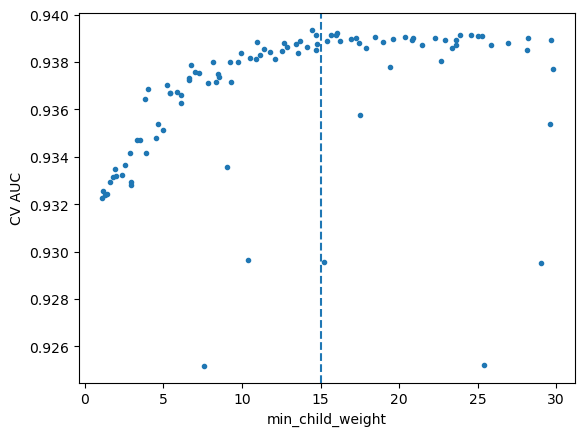

In [11]:
fig, ax = plt.subplots()
ax.plot(min_childs, aucs, '.')
ax.axvline(15, linestyle='--')
ax.set_xlabel('min_child_weight')
ax.set_ylabel('CV AUC')

Here we will find that an optimal subsample value would be 0.95 due to a malignly higher concentration of high preforming models. Most values seem to give good enough results.

Text(0, 0.5, 'CV AUC')

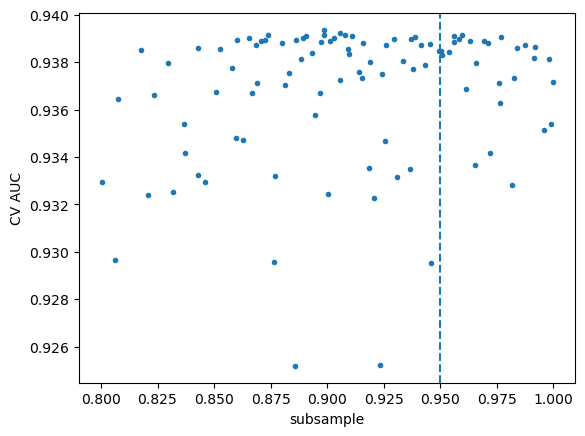

In [12]:
fig, ax = plt.subplots()
ax.plot(subsample, aucs, '.')
ax.axvline(.95, linestyle='--')
ax.set_xlabel('subsample')
ax.set_ylabel('CV AUC')

We can now determine, with these new values, what the optimal number of n_estimators is.

In [13]:
model = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 15,
                         scale_pos_weight = trainingBalance)

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=400)

[0]	train-auc:0.95148+0.00059	test-auc:0.92479+0.00270
[1]	train-auc:0.95939+0.00026	test-auc:0.93289+0.00313
[2]	train-auc:0.96247+0.00044	test-auc:0.93582+0.00290
[3]	train-auc:0.96417+0.00036	test-auc:0.93764+0.00297
[4]	train-auc:0.96546+0.00027	test-auc:0.93878+0.00322
[5]	train-auc:0.96651+0.00035	test-auc:0.93959+0.00309
[6]	train-auc:0.96744+0.00035	test-auc:0.94049+0.00296
[7]	train-auc:0.96829+0.00033	test-auc:0.94117+0.00280
[8]	train-auc:0.96899+0.00038	test-auc:0.94160+0.00272
[9]	train-auc:0.96962+0.00032	test-auc:0.94200+0.00278
[10]	train-auc:0.97031+0.00034	test-auc:0.94240+0.00266
[11]	train-auc:0.97090+0.00035	test-auc:0.94271+0.00260
[12]	train-auc:0.97151+0.00030	test-auc:0.94309+0.00262
[13]	train-auc:0.97208+0.00033	test-auc:0.94344+0.00262
[14]	train-auc:0.97264+0.00036	test-auc:0.94381+0.00255
[15]	train-auc:0.97311+0.00038	test-auc:0.94411+0.00251
[16]	train-auc:0.97363+0.00034	test-auc:0.94446+0.00244
[17]	train-auc:0.97407+0.00033	test-auc:0.94471+0.00244
[1

Here we will find that an optimal number of estimators would be about 125.

Text(0, 0.5, 'CV AUC score')

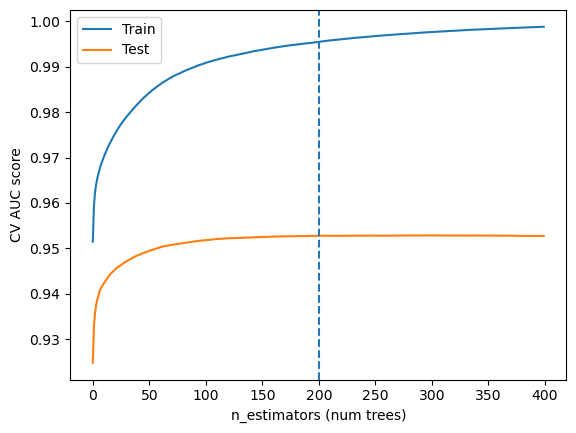

In [14]:
n_estimators = 200
fig, ax = plt.subplots()
ax.plot(score.index, score['train-auc-mean'], label='Train')
ax.plot(score.index, score['test-auc-mean'], label='Test')
ax.axvline(n_estimators, linestyle='--')
ax.legend()
ax.set_xlabel('n_estimators (num trees)')
ax.set_ylabel('CV AUC score')

# SPOCK

We can now train the final spock model

In [15]:
dataset['logTmax']=np.log10(dataset['Tmax'])

In [16]:
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

In [17]:
model = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 15,
                         n_estimators = 200,
                         scale_pos_weight=trainingBalance)


In [18]:
model.fit(trainX,trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=15, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Text(0.5, 1.0, 'ROC curve (AUC = 0.952)')

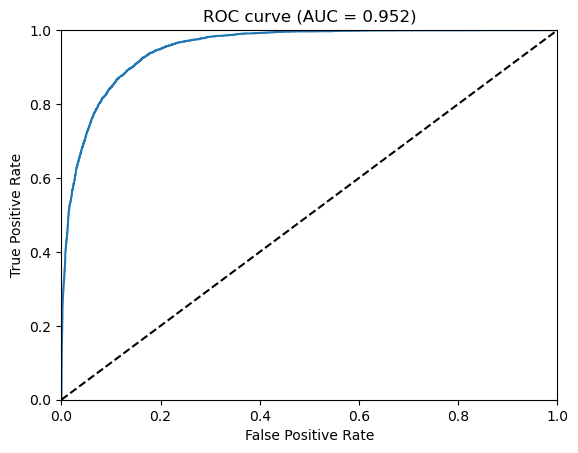

In [19]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX, testY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [20]:
#check exact number
roc_auc

0.9522110698532896

We can check FPR when we have a TPR of .9

In [21]:
tprthreshindex = np.where(tpr >=0.9)[0][0]
fpr[tprthreshindex]

0.14367176634214188

We can check feature importance

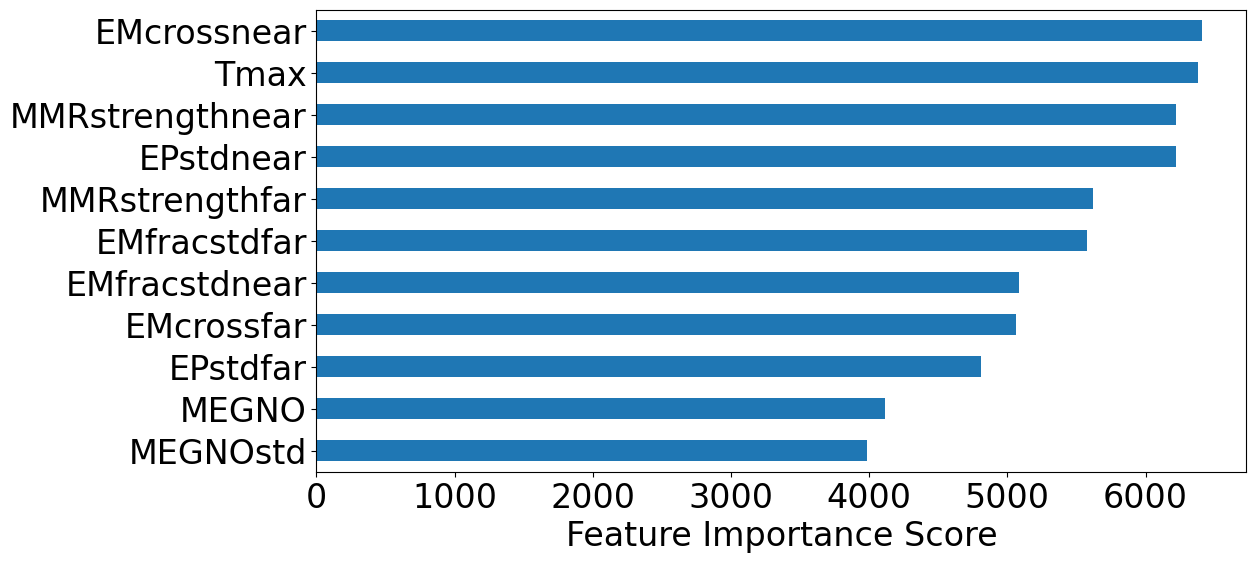

In [22]:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,6), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()

Here we can see that the model trained with features generated by integrating to 5 times the secular time scale preforms only slightly better then if you only integrate to 1e4. Since integrating based on the secular time scale has a large negative impact on the computational power required, we can conclude that the cost is not worth the benifit.

array([[<Axes: title={'center': 'logTmax'}>]], dtype=object)

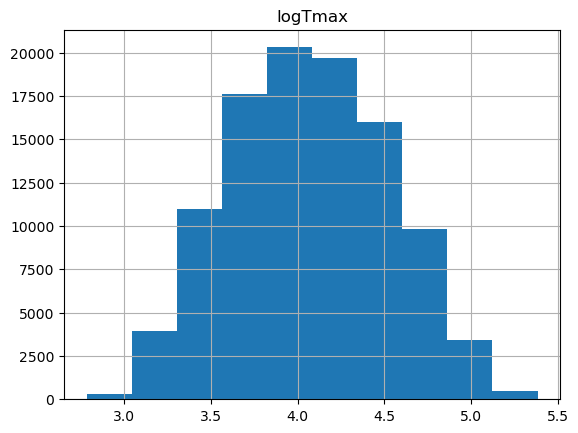

In [23]:
dataset.hist('logTmax')

# Comparing to original spock model

In [46]:
#load datapath for clean training data that was integrated to 1e4
datapath = '../../cleanData/csvs/resonant/'

regtime = pd.read_csv(datapath+'CleanResTrainingData.csv')
#remove junk columns
regtime = regtime.drop(columns=['Unnamed: 0','Unnamed: 0.1'])
regtime = regtime[features[:-1]+['Stable','InitialStable']]
#keep track of which systems are unstable in secular timescale
initStab = (dataset ['InitialStable'] ==1) & (regtime ['InitialStable'] ==1) 

We will not test on systems that are initially unstable in either short intigration

In [40]:
regtime['InitialStable']= initStab
dataset['InitialStable']= initStab
# overwrite initial stable so we can use our automated filtration to compair

re split data into training and testing

In [47]:
Otrainx,Otrainy,Otestx,OtestY =train_test(regtime, features[:-1]) # removing Tmax as a feature for the old model
Otrainx,Otrainy,TsecX,TsecY =train_test(regtime, features[:-1]) 
#training data does not matter

# Evaluate Old

Text(0.5, 1.0, 'ROC curve (AUC = 0.944)')

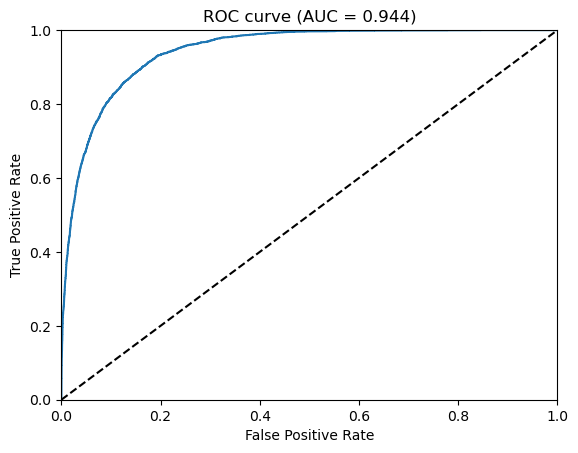

In [48]:
from spock import FeatureClassifier
spock = FeatureClassifier()
# evaluates old model trained with 1e4 integrations on data
Oldauc, Oldfpr, Oldtpr, ROCthresholds = ROC_curve(spock.model, Otestx, OtestY)


fig, ax = plt.subplots()
ax.plot(Oldfpr, Oldtpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(Oldauc))

In [49]:
Oldauc

0.9436352768410051

In [50]:
tprthreshindex = np.where(Oldtpr >=0.9)[0][0]
Oldfpr[tprthreshindex]

0.163252508361204

# Evaluate model integrated to secular time scale

Text(0.5, 1.0, 'ROC curve (AUC = 0.952)')

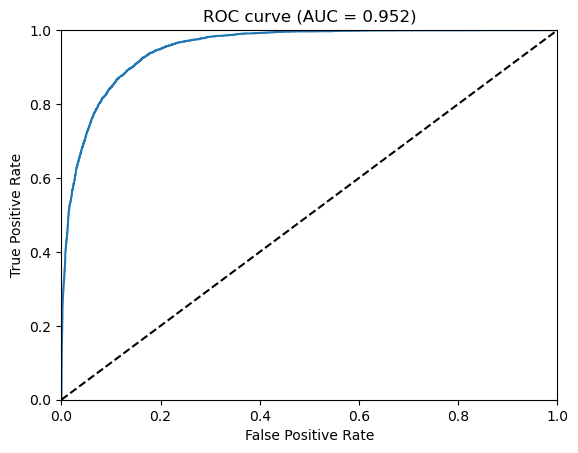

In [51]:
Tsecauc, Tsecfpr, Tsectpr, ROCthresholds = ROC_curve(model, testX, testY)

fig, ax = plt.subplots()
ax.plot(Tsecfpr, Tsectpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(Tsecauc))

In [52]:
Tsecauc

0.9522110698532896

In [53]:
tprthreshindex = np.where(Tsectpr >=0.9)[0][0]
Tsecfpr[tprthreshindex]

0.14367176634214188

# Comparison
When evaluated on the same testing data set where no system goes unstable in either short integration

Integrating to secular time scale has a AUC of **0.9522** and a FPR when TPR=0.9 of **0.1437**

Integrating to 1e4 orbits evaluated on systems that are stable in both after integration has a AUC of **0.9436** and a FPR when TPR=0.9 of **0.1633**

**Conclusion**

Integrating to one secular time scale and passing the time scale forward as a feature results in a increase of AUC by 0.86 percentage points and a decrease in FPR by 1.96 percentage points when being evaluated on the same dataset. 